### Models of the USA 

In [1]:
# import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# for linear regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# for neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import random

In [5]:
# fot tda summaries
from utills.svi import svi_tda_summaries


Define the model variables as follows:

In [6]:
variables = [
    'EP_POV', 'EP_UNEMP', 'EP_PCI', 'EP_NOHSDP', 'EP_UNINSUR', 'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 
    'EP_SNGPNT', 'EP_LIMENG', 'EP_MINRTY', 'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD', 'EP_NOVEH', 'EP_GROUPQ'
    ]

SMR and Scaled\Null values treated as average:

In [7]:
scaled_svi_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/USA_SVI_2018_cleaned.gdb"
smr_national_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/smr_usa_2018.csv"

In [8]:
def run_linear_regression(X, y, test_size=0.2, random_state=0):
    """
    Splits the data, fits a linear regression model, and returns the model and evaluation metrics.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return regressor, mse, r2, y_test, y_pred

In [9]:
def experiment_tda(smr_df_path, cleaned_svi_data_path,save_path, variables, regex_filter, model_name, year, filter_method='up'):
    """
    Experiment using TDA summaries (from tract-level SVI data) with a given column suffix filter.
    
    Parameters:
        smr_df         : DataFrame with SMR results.
        svi_data_path  : Path to the tract-level SVI data.
        variables      : List of SVI variables.
        column_suffix  : Suffix to filter columns (e.g., 'TL' or 'AL').
        model_name     : Name to label this experiment.
        filter_method  : Filtering method to use (default 'up').
    """

    # set the random seed
    random.seed(0)
    np.random.seed(0)

    # Load the SMR data.
    smr_national_df = pd.read_csv(smr_df_path, dtype={'FIPS': str})


    # let's create a file name for the output file
    output_file_name = f'tda_svi_summaries_{year}_{filter_method}.csv'
    out_put_file_path = os.path.join(save_path, output_file_name)

    # check if the file already exists, if it does, load it and return
    if os.path.exists(out_put_file_path):
        print(f'File {out_put_file_path} already exists. Skipping...')
        #load the file
        svi_summary_df = pd.read_csv(out_put_file_path, dtype={'STCNTY': str})
    else:
        print(f'File {out_put_file_path} does not exists. Running...')
        svi_tda = svi_tda_summaries(cleaned_svi_data_path, variables, filter_method=filter_method)
        svi_tda.filter_clean_gdf()
        svi_summary_df = svi_tda.compute_tda_summaries_svi()
        svi_summary_df.to_csv(out_put_file_path)

    # Merge the SMR data with the SVI data.
    merged_df = pd.merge(svi_summary_df,smr_national_df, left_on='STCNTY', right_on='FIPS', how='left')    

    # drop rows where SMR is 0
    merged_df = merged_df[merged_df.SMR != 0]

    print(f'\nMerged dataframe has shape: {merged_df.shape}')

    # print(f'merged_df columns: {merged_df.columns}')

    # Filter the merged dataframe to include SMR, FIPS and columns with the given suffix.
    # regex_filter = f'_{column_suffix}|SMR|FIPS'
    filtered_df = merged_df.filter(regex=regex_filter)

    # Set FIPS as index and define features/target.
    filtered_df.set_index('FIPS', inplace=True)
    X = filtered_df.drop(columns=['SMR'])
    y = filtered_df['SMR']

    print(f'\nX columns: {X.columns.values}')
    # print the numer of variables
    print(f'\nNumber of variables: {len(X.columns)}')

    # Run regression
    regressor, mse, r2, y_test, y_pred = run_linear_regression(X, y)
    coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=[model_name])
    # Optionally, remove the suffix from coefficient indices for cleaner display.
    # coeff_df.index = coeff_df.index.str.replace(f'_{column_suffix}', '')

    print(f'\n------Results------')

    print(f'\nRegression model traind with MSE: {mse} and R2: {r2}')

    return {
        'model_name': model_name,
        'filtration': filter_method,
        'mse': mse,
        'r2': r2,
        # 'coefficients': coeff_df,
        'y_test': y_test,
        'y_pred': y_pred
    }


In [10]:

# Set random seed for reproducibility
def set_random_seed(seed_value=42):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    random.seed(seed_value)

def experiment_tda_nn(smr_df_path, cleaned_svi_data_path, save_path, variables, regex_filter, model_name, year, filter_method='up', epochs=100, batch_size=32):
    """
    Experiment using TDA summaries with a Neural Network regression model.
    
    Parameters:
        smr_df_path       : Path to the SMR results CSV.
        cleaned_svi_data_path : Path to the cleaned SVI data.
        save_path        : Directory to save results.
        variables        : List of SVI variables.
        regex_filter     : Regex pattern to filter columns.
        model_name       : Name for experiment.
        year            : Year of the dataset.
        filter_method   : Filtering method (default 'up').
        epochs         : Number of training epochs.
        batch_size     : Batch size for training.

    """

    set_random_seed()

    # Load the SMR data.
    smr_national_df = pd.read_csv(smr_df_path, dtype={'FIPS': str})
    
    # Define output file name
    output_file_name = f'tda_svi_summaries_{year}_{filter_method}.csv'
    out_put_file_path = os.path.join(save_path, output_file_name)
    
    # Check if the summary file already exists
    if os.path.exists(out_put_file_path):
        print(f'File {out_put_file_path} already exists. Loading...')
        svi_summary_df = pd.read_csv(out_put_file_path, dtype={'STCNTY': str})
    else:
        print(f'File {out_put_file_path} not found. Generating...')
        svi_tda = svi_tda_summaries(cleaned_svi_data_path, variables, filter_method=filter_method)
        svi_tda.filter_clean_gdf()
        svi_summary_df = svi_tda.compute_tda_summaries_svi()
        svi_summary_df.to_csv(out_put_file_path, index=False)
    
    # Merge the SMR data with the SVI data
    merged_df = pd.merge(svi_summary_df, smr_national_df, left_on='STCNTY', right_on='FIPS', how='left')    
    merged_df = merged_df[merged_df.SMR != 0]  # Drop rows where SMR is 0
    
    print(f'\nMerged dataframe shape: {merged_df.shape}')
    
    # Filter dataframe using regex filter
    filtered_df = merged_df.filter(regex=regex_filter)
    filtered_df.set_index('FIPS', inplace=True)
    
    # Define features (X) and target (y)
    X = filtered_df.drop(columns=['SMR'])
    y = filtered_df['SMR']
    
    print(f'\nFeature columns: {X.columns.values}')
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # # Build Neural Network Model
    # model = Sequential([
    #     Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    #     Dropout(0.2),
    #     Dense(32, activation='relu'),
    #     Dropout(0.2),
    #     Dense(1)  # Regression output
    # ])

    model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1)  # Regression output
    ])
    
    
    # Compile model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.show()
    
    # Evaluate model
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test).flatten()
    
    print(f'\nNeural Network trained with MSE: {test_loss:.4f}, MAE: {test_mae:.4f}')
    
    return {
        'model_name': model_name,
        'filtration': filter_method,
        'mse': test_loss,
        'mae': test_mae,
        'y_test': y_test.tolist(),
        'y_pred': y_pred.tolist()
    }

### DOWN FILTER

Original data only

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_down.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_AV_ORI' 'EP_UNEMP_AV_ORI' 'EP_PCI_AV_ORI' 'EP_NOHSDP_AV_ORI'
 'EP_UNINSUR_AV_ORI' 'EP_AGE65_AV_ORI' 'EP_AGE17_AV_ORI'
 'EP_DISABL_AV_ORI' 'EP_SNGPNT_AV_ORI' 'EP_LIMENG_AV_ORI'
 'EP_MINRTY_AV_ORI' 'EP_MUNIT_AV_ORI' 'EP_MOBILE_AV_ORI' 'EP_CROWD_AV_ORI'
 'EP_NOVEH_AV_ORI' 'EP_GROUPQ_AV_ORI']

Number of variables: 16

------Results------

Regression model traind with MSE: 0.07338541656213103 and R2: 0.07112803222784225


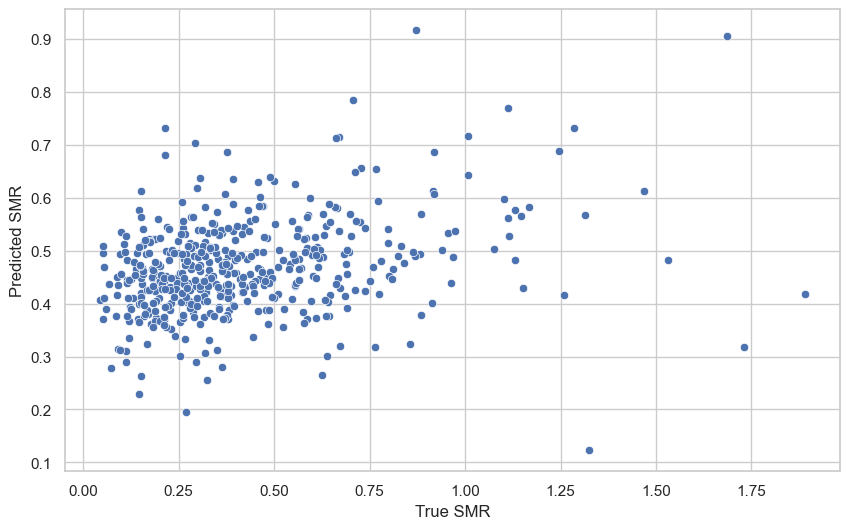

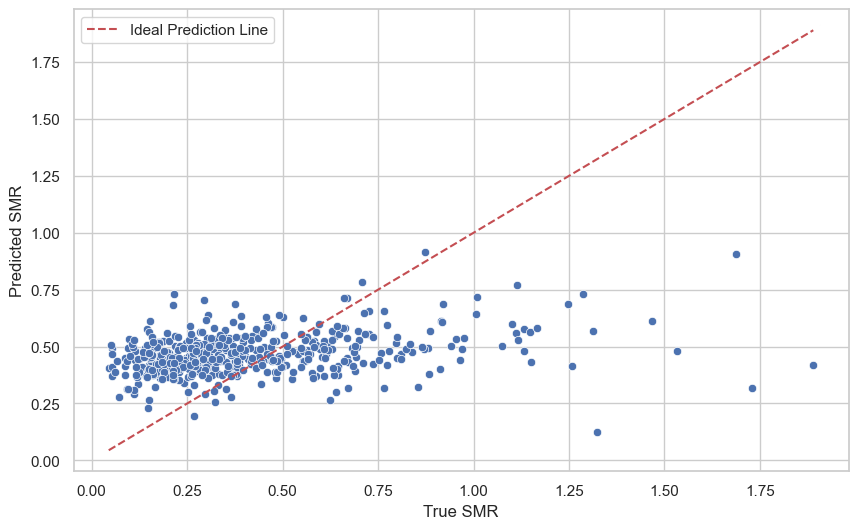

In [65]:
original = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_AV_ORI|SMR|FIPS', 
                    model_name = 'ORIGINAL', 
                    year='2018', 
                    filter_method='down')

sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.scatterplot(x=original['y_test'], y=original['y_pred'])
plt.xlabel('True SMR')
plt.ylabel('Predicted SMR')

plt.show()


sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))

# Scatter plot of predicted vs. true values
sns.scatterplot(x=original['y_test'], y=original['y_pred'])

# Add a red dotted identity line (y = x)
x_range = np.linspace(min(original['y_test']), max(original['y_test']), 100)
plt.plot(x_range, x_range, 'r--', label='Ideal Prediction Line')

# Labels and legend
plt.xlabel('True SMR')
plt.ylabel('Predicted SMR')
plt.legend()

plt.show()

In [12]:
model_1_d = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_AL|SMR|FIPS', 
                    model_name = 'AL', 
                    year='2018', 
                    filter_method='down')


File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_down.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_AL' 'EP_UNEMP_AL' 'EP_PCI_AL' 'EP_NOHSDP_AL' 'EP_UNINSUR_AL'
 'EP_AGE65_AL' 'EP_AGE17_AL' 'EP_DISABL_AL' 'EP_SNGPNT_AL' 'EP_LIMENG_AL'
 'EP_MINRTY_AL' 'EP_MUNIT_AL' 'EP_MOBILE_AL' 'EP_CROWD_AL' 'EP_NOVEH_AL'
 'EP_GROUPQ_AL']

Number of variables: 16

------Results------

Regression model traind with MSE: 0.07419096801844215 and R2: 0.06093180794488906


In [13]:
model_2_d = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_TL|SMR|FIPS', 
                    model_name = 'TL', 
                    year='2018', 
                    filter_method='down')


File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_down.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_TL' 'EP_UNEMP_TL' 'EP_PCI_TL' 'EP_NOHSDP_TL' 'EP_UNINSUR_TL'
 'EP_AGE65_TL' 'EP_AGE17_TL' 'EP_DISABL_TL' 'EP_SNGPNT_TL' 'EP_LIMENG_TL'
 'EP_MINRTY_TL' 'EP_MUNIT_TL' 'EP_MOBILE_TL' 'EP_CROWD_TL' 'EP_NOVEH_TL'
 'EP_GROUPQ_TL']

Number of variables: 16

------Results------

Regression model traind with MSE: 0.07502983531508071 and R2: 0.05031389020276289


In [14]:
model_3_d = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_TML|SMR|FIPS', 
                    model_name = 'TML', 
                    year='2018', 
                    filter_method='down')


File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_down.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_TML' 'EP_UNEMP_TML' 'EP_PCI_TML' 'EP_NOHSDP_TML' 'EP_UNINSUR_TML'
 'EP_AGE65_TML' 'EP_AGE17_TML' 'EP_DISABL_TML' 'EP_SNGPNT_TML'
 'EP_LIMENG_TML' 'EP_MINRTY_TML' 'EP_MUNIT_TML' 'EP_MOBILE_TML'
 'EP_CROWD_TML' 'EP_NOVEH_TML' 'EP_GROUPQ_TML']

Number of variables: 16

------Results------

Regression model traind with MSE: 0.07502983531508071 and R2: 0.05031389020276289


In [15]:
model_4_d = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_AML|SMR|FIPS', 
                    model_name = 'AML', 
                    year='2018', 
                    filter_method='down')


File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_down.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_AML' 'EP_UNEMP_AML' 'EP_PCI_AML' 'EP_NOHSDP_AML' 'EP_UNINSUR_AML'
 'EP_AGE65_AML' 'EP_AGE17_AML' 'EP_DISABL_AML' 'EP_SNGPNT_AML'
 'EP_LIMENG_AML' 'EP_MINRTY_AML' 'EP_MUNIT_AML' 'EP_MOBILE_AML'
 'EP_CROWD_AML' 'EP_NOVEH_AML' 'EP_GROUPQ_AML']

Number of variables: 16

------Results------

Regression model traind with MSE: 0.07419096801844215 and R2: 0.06093180794488906


Combined with original data

In [16]:
model_5_d = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_AV_ORI|_TL|SMR|FIPS', 
                    model_name = 'ORIGINAL+TL', 
                    year='2018', 
                    filter_method='down')


File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_down.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_TL' 'EP_POV_AV_ORI' 'EP_UNEMP_TL' 'EP_UNEMP_AV_ORI' 'EP_PCI_TL'
 'EP_PCI_AV_ORI' 'EP_NOHSDP_TL' 'EP_NOHSDP_AV_ORI' 'EP_UNINSUR_TL'
 'EP_UNINSUR_AV_ORI' 'EP_AGE65_TL' 'EP_AGE65_AV_ORI' 'EP_AGE17_TL'
 'EP_AGE17_AV_ORI' 'EP_DISABL_TL' 'EP_DISABL_AV_ORI' 'EP_SNGPNT_TL'
 'EP_SNGPNT_AV_ORI' 'EP_LIMENG_TL' 'EP_LIMENG_AV_ORI' 'EP_MINRTY_TL'
 'EP_MINRTY_AV_ORI' 'EP_MUNIT_TL' 'EP_MUNIT_AV_ORI' 'EP_MOBILE_TL'
 'EP_MOBILE_AV_ORI' 'EP_CROWD_TL' 'EP_CROWD_AV_ORI' 'EP_NOVEH_TL'
 'EP_NOVEH_AV_ORI' 'EP_GROUPQ_TL' 'EP_GROUPQ_AV_ORI']

Number of variables: 32

------Results------

Regression model traind with MSE: 0.070913814825173 and R2: 0.10241219843562788


File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_down.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_AL' 'EP_POV_AV_ORI' 'EP_UNEMP_AL' 'EP_UNEMP_AV_ORI' 'EP_PCI_AL'
 'EP_PCI_AV_ORI' 'EP_NOHSDP_AL' 'EP_NOHSDP_AV_ORI' 'EP_UNINSUR_AL'
 'EP_UNINSUR_AV_ORI' 'EP_AGE65_AL' 'EP_AGE65_AV_ORI' 'EP_AGE17_AL'
 'EP_AGE17_AV_ORI' 'EP_DISABL_AL' 'EP_DISABL_AV_ORI' 'EP_SNGPNT_AL'
 'EP_SNGPNT_AV_ORI' 'EP_LIMENG_AL' 'EP_LIMENG_AV_ORI' 'EP_MINRTY_AL'
 'EP_MINRTY_AV_ORI' 'EP_MUNIT_AL' 'EP_MUNIT_AV_ORI' 'EP_MOBILE_AL'
 'EP_MOBILE_AV_ORI' 'EP_CROWD_AL' 'EP_CROWD_AV_ORI' 'EP_NOVEH_AL'
 'EP_NOVEH_AV_ORI' 'EP_GROUPQ_AL' 'EP_GROUPQ_AV_ORI']

Number of variables: 32

------Results------

Regression model traind with MSE: 0.06939810213412231 and R2: 0.12159725039648306


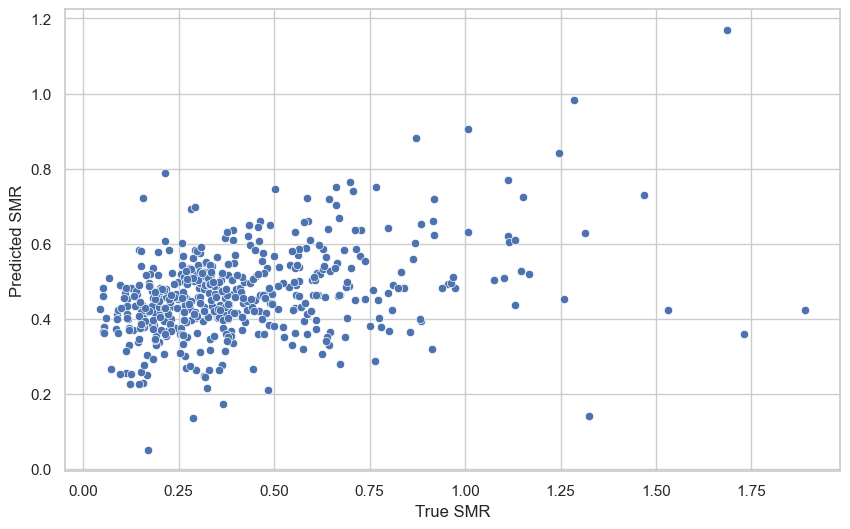

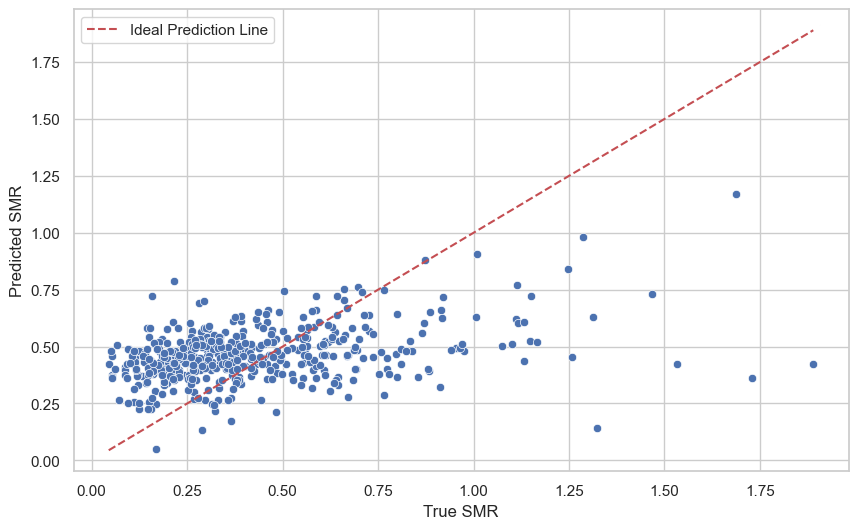

In [64]:
model_6_d = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_AV_ORI|_AL|SMR|FIPS', 
                    model_name = 'ORIGINAL+AL', 
                    year='2018', 
                    filter_method='down')


sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.scatterplot(x=model_6_d['y_test'], y=model_6_d['y_pred'])
plt.xlabel('True SMR')
plt.ylabel('Predicted SMR')

plt.show()


sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))

# Scatter plot of predicted vs. true values
sns.scatterplot(x=model_6_d['y_test'], y=model_6_d['y_pred'])

# Add a red dotted identity line (y = x)
x_range = np.linspace(min(model_6_d['y_test']), max(model_6_d['y_test']), 100)
plt.plot(x_range, x_range, 'r--', label='Ideal Prediction Line')

# Labels and legend
plt.xlabel('True SMR')
plt.ylabel('Predicted SMR')
plt.legend()

In [18]:
model_7_d = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_AV_ORI|_TML|SMR|FIPS', 
                    model_name = 'ORIGINAL+TML', 
                    year='2018', 
                    filter_method='down')

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_down.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_TML' 'EP_POV_AV_ORI' 'EP_UNEMP_TML' 'EP_UNEMP_AV_ORI'
 'EP_PCI_TML' 'EP_PCI_AV_ORI' 'EP_NOHSDP_TML' 'EP_NOHSDP_AV_ORI'
 'EP_UNINSUR_TML' 'EP_UNINSUR_AV_ORI' 'EP_AGE65_TML' 'EP_AGE65_AV_ORI'
 'EP_AGE17_TML' 'EP_AGE17_AV_ORI' 'EP_DISABL_TML' 'EP_DISABL_AV_ORI'
 'EP_SNGPNT_TML' 'EP_SNGPNT_AV_ORI' 'EP_LIMENG_TML' 'EP_LIMENG_AV_ORI'
 'EP_MINRTY_TML' 'EP_MINRTY_AV_ORI' 'EP_MUNIT_TML' 'EP_MUNIT_AV_ORI'
 'EP_MOBILE_TML' 'EP_MOBILE_AV_ORI' 'EP_CROWD_TML' 'EP_CROWD_AV_ORI'
 'EP_NOVEH_TML' 'EP_NOVEH_AV_ORI' 'EP_GROUPQ_TML' 'EP_GROUPQ_AV_ORI']

Number of variables: 32

------Results------

Regression model traind with MSE: 0.07091381482517295 and R2: 0.10241219843562865


In [19]:
model_8_d = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_AV_ORI|_AML|SMR|FIPS', 
                    model_name = 'ORIGINAL+AML', 
                    year='2018', 
                    filter_method='down')

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_down.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_AML' 'EP_POV_AV_ORI' 'EP_UNEMP_AML' 'EP_UNEMP_AV_ORI'
 'EP_PCI_AML' 'EP_PCI_AV_ORI' 'EP_NOHSDP_AML' 'EP_NOHSDP_AV_ORI'
 'EP_UNINSUR_AML' 'EP_UNINSUR_AV_ORI' 'EP_AGE65_AML' 'EP_AGE65_AV_ORI'
 'EP_AGE17_AML' 'EP_AGE17_AV_ORI' 'EP_DISABL_AML' 'EP_DISABL_AV_ORI'
 'EP_SNGPNT_AML' 'EP_SNGPNT_AV_ORI' 'EP_LIMENG_AML' 'EP_LIMENG_AV_ORI'
 'EP_MINRTY_AML' 'EP_MINRTY_AV_ORI' 'EP_MUNIT_AML' 'EP_MUNIT_AV_ORI'
 'EP_MOBILE_AML' 'EP_MOBILE_AV_ORI' 'EP_CROWD_AML' 'EP_CROWD_AV_ORI'
 'EP_NOVEH_AML' 'EP_NOVEH_AV_ORI' 'EP_GROUPQ_AML' 'EP_GROUPQ_AV_ORI']

Number of variables: 32

------Results------

Regression model traind with MSE: 0.0693981021341223 and R2: 0.12159725039648328


Multiple combinations of the original data

In [20]:
model_9_d = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_AV_ORI|_TL|_TML|SMR|FIPS', 
                    model_name = 'ORIGINAL+TL+TML', 
                    year='2018', 
                    filter_method='down')

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_down.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_TL' 'EP_POV_TML' 'EP_POV_AV_ORI' 'EP_UNEMP_TL' 'EP_UNEMP_TML'
 'EP_UNEMP_AV_ORI' 'EP_PCI_TL' 'EP_PCI_TML' 'EP_PCI_AV_ORI' 'EP_NOHSDP_TL'
 'EP_NOHSDP_TML' 'EP_NOHSDP_AV_ORI' 'EP_UNINSUR_TL' 'EP_UNINSUR_TML'
 'EP_UNINSUR_AV_ORI' 'EP_AGE65_TL' 'EP_AGE65_TML' 'EP_AGE65_AV_ORI'
 'EP_AGE17_TL' 'EP_AGE17_TML' 'EP_AGE17_AV_ORI' 'EP_DISABL_TL'
 'EP_DISABL_TML' 'EP_DISABL_AV_ORI' 'EP_SNGPNT_TL' 'EP_SNGPNT_TML'
 'EP_SNGPNT_AV_ORI' 'EP_LIMENG_TL' 'EP_LIMENG_TML' 'EP_LIMENG_AV_ORI'
 'EP_MINRTY_TL' 'EP_MINRTY_TML' 'EP_MINRTY_AV_ORI' 'EP_MUNIT_TL'
 'EP_MUNIT_TML' 'EP_MUNIT_AV_ORI' 'EP_MOBILE_TL' 'EP_MOBILE_TML'
 'EP_MOBILE_AV_ORI' 'EP_CROWD_TL' 'EP_CROWD_TML' 'EP_CROWD_AV_ORI'
 'EP_NOVEH_TL' 'EP_NOVEH_TML' 'EP_NOVEH_AV_ORI' 'EP_GROUPQ_TL'
 'EP_GROUPQ_TML' 'EP_GROUPQ_AV_ORI']

Number of variables: 48


In [21]:
model_10_d = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_AV_ORI|_AL|_AML|SMR|FIPS', 
                    model_name = 'ORIGINAL+AL+AML', 
                    year='2018', 
                    filter_method='down')

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_down.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_AL' 'EP_POV_AML' 'EP_POV_AV_ORI' 'EP_UNEMP_AL' 'EP_UNEMP_AML'
 'EP_UNEMP_AV_ORI' 'EP_PCI_AL' 'EP_PCI_AML' 'EP_PCI_AV_ORI' 'EP_NOHSDP_AL'
 'EP_NOHSDP_AML' 'EP_NOHSDP_AV_ORI' 'EP_UNINSUR_AL' 'EP_UNINSUR_AML'
 'EP_UNINSUR_AV_ORI' 'EP_AGE65_AL' 'EP_AGE65_AML' 'EP_AGE65_AV_ORI'
 'EP_AGE17_AL' 'EP_AGE17_AML' 'EP_AGE17_AV_ORI' 'EP_DISABL_AL'
 'EP_DISABL_AML' 'EP_DISABL_AV_ORI' 'EP_SNGPNT_AL' 'EP_SNGPNT_AML'
 'EP_SNGPNT_AV_ORI' 'EP_LIMENG_AL' 'EP_LIMENG_AML' 'EP_LIMENG_AV_ORI'
 'EP_MINRTY_AL' 'EP_MINRTY_AML' 'EP_MINRTY_AV_ORI' 'EP_MUNIT_AL'
 'EP_MUNIT_AML' 'EP_MUNIT_AV_ORI' 'EP_MOBILE_AL' 'EP_MOBILE_AML'
 'EP_MOBILE_AV_ORI' 'EP_CROWD_AL' 'EP_CROWD_AML' 'EP_CROWD_AV_ORI'
 'EP_NOVEH_AL' 'EP_NOVEH_AML' 'EP_NOVEH_AV_ORI' 'EP_GROUPQ_AL'
 'EP_GROUPQ_AML' 'EP_GROUPQ_AV_ORI']

Number of variables: 48


In [22]:
model_11_d = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_AV_ORI|_TL|_AML|SMR|FIPS', 
                    model_name = 'ORIGINAL+TL+AML', 
                    year='2018', 
                    filter_method='down')

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_down.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_TL' 'EP_POV_AML' 'EP_POV_AV_ORI' 'EP_UNEMP_TL' 'EP_UNEMP_AML'
 'EP_UNEMP_AV_ORI' 'EP_PCI_TL' 'EP_PCI_AML' 'EP_PCI_AV_ORI' 'EP_NOHSDP_TL'
 'EP_NOHSDP_AML' 'EP_NOHSDP_AV_ORI' 'EP_UNINSUR_TL' 'EP_UNINSUR_AML'
 'EP_UNINSUR_AV_ORI' 'EP_AGE65_TL' 'EP_AGE65_AML' 'EP_AGE65_AV_ORI'
 'EP_AGE17_TL' 'EP_AGE17_AML' 'EP_AGE17_AV_ORI' 'EP_DISABL_TL'
 'EP_DISABL_AML' 'EP_DISABL_AV_ORI' 'EP_SNGPNT_TL' 'EP_SNGPNT_AML'
 'EP_SNGPNT_AV_ORI' 'EP_LIMENG_TL' 'EP_LIMENG_AML' 'EP_LIMENG_AV_ORI'
 'EP_MINRTY_TL' 'EP_MINRTY_AML' 'EP_MINRTY_AV_ORI' 'EP_MUNIT_TL'
 'EP_MUNIT_AML' 'EP_MUNIT_AV_ORI' 'EP_MOBILE_TL' 'EP_MOBILE_AML'
 'EP_MOBILE_AV_ORI' 'EP_CROWD_TL' 'EP_CROWD_AML' 'EP_CROWD_AV_ORI'
 'EP_NOVEH_TL' 'EP_NOVEH_AML' 'EP_NOVEH_AV_ORI' 'EP_GROUPQ_TL'
 'EP_GROUPQ_AML' 'EP_GROUPQ_AV_ORI']

Number of variables: 48


In [23]:
model_12_d = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_AV_ORI|_AL|_TML|SMR|FIPS', 
                    model_name = 'ORIGINAL+AL+TML', 
                    year='2018', 
                    filter_method='down')

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_down.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_AL' 'EP_POV_TML' 'EP_POV_AV_ORI' 'EP_UNEMP_AL' 'EP_UNEMP_TML'
 'EP_UNEMP_AV_ORI' 'EP_PCI_AL' 'EP_PCI_TML' 'EP_PCI_AV_ORI' 'EP_NOHSDP_AL'
 'EP_NOHSDP_TML' 'EP_NOHSDP_AV_ORI' 'EP_UNINSUR_AL' 'EP_UNINSUR_TML'
 'EP_UNINSUR_AV_ORI' 'EP_AGE65_AL' 'EP_AGE65_TML' 'EP_AGE65_AV_ORI'
 'EP_AGE17_AL' 'EP_AGE17_TML' 'EP_AGE17_AV_ORI' 'EP_DISABL_AL'
 'EP_DISABL_TML' 'EP_DISABL_AV_ORI' 'EP_SNGPNT_AL' 'EP_SNGPNT_TML'
 'EP_SNGPNT_AV_ORI' 'EP_LIMENG_AL' 'EP_LIMENG_TML' 'EP_LIMENG_AV_ORI'
 'EP_MINRTY_AL' 'EP_MINRTY_TML' 'EP_MINRTY_AV_ORI' 'EP_MUNIT_AL'
 'EP_MUNIT_TML' 'EP_MUNIT_AV_ORI' 'EP_MOBILE_AL' 'EP_MOBILE_TML'
 'EP_MOBILE_AV_ORI' 'EP_CROWD_AL' 'EP_CROWD_TML' 'EP_CROWD_AV_ORI'
 'EP_NOVEH_AL' 'EP_NOVEH_TML' 'EP_NOVEH_AV_ORI' 'EP_GROUPQ_AL'
 'EP_GROUPQ_TML' 'EP_GROUPQ_AV_ORI']

Number of variables: 48


NN Models

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_down.csv already exists. Loading...

Merged dataframe shape: (2402, 87)

Feature columns: ['EP_POV_AL' 'EP_POV_AV_ORI' 'EP_UNEMP_AL' 'EP_UNEMP_AV_ORI' 'EP_PCI_AL'
 'EP_PCI_AV_ORI' 'EP_NOHSDP_AL' 'EP_NOHSDP_AV_ORI' 'EP_UNINSUR_AL'
 'EP_UNINSUR_AV_ORI' 'EP_AGE65_AL' 'EP_AGE65_AV_ORI' 'EP_AGE17_AL'
 'EP_AGE17_AV_ORI' 'EP_DISABL_AL' 'EP_DISABL_AV_ORI' 'EP_SNGPNT_AL'
 'EP_SNGPNT_AV_ORI' 'EP_LIMENG_AL' 'EP_LIMENG_AV_ORI' 'EP_MINRTY_AL'
 'EP_MINRTY_AV_ORI' 'EP_MUNIT_AL' 'EP_MUNIT_AV_ORI' 'EP_MOBILE_AL'
 'EP_MOBILE_AV_ORI' 'EP_CROWD_AL' 'EP_CROWD_AV_ORI' 'EP_NOVEH_AL'
 'EP_NOVEH_AV_ORI' 'EP_GROUPQ_AL' 'EP_GROUPQ_AV_ORI']
Epoch 1/500


/Users/h6x/anaconda3/envs/pymc_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2568 - mae: 1.1573 - val_loss: 0.1440 - val_mae: 0.2426
Epoch 2/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 0.8318 - mae: 0.7292 - val_loss: 0.1533 - val_mae: 0.2641
Epoch 3/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 0.5645 - mae: 0.5872 - val_loss: 0.1402 - val_mae: 0.2565
Epoch 4/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 0.3667 - mae: 0.4751 - val_loss: 0.1251 - val_mae: 0.2316
Epoch 5/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 0.2761 - mae: 0.4055 - val_loss: 0.1207 - val_mae: 0.2280
Epoch 6/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.2290 - mae: 0.3656 - val_loss: 0.1176 - val_mae: 0.2256
Epoch 7/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 0.1838 - mae: 0.3290 - val_loss: 0.1177 - val_mae: 0.2261
Epoch 8/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 0.1547 - mae: 0.2966 - val_loss: 0.1176 - val_mae: 0.2227
Epoch 9/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 97

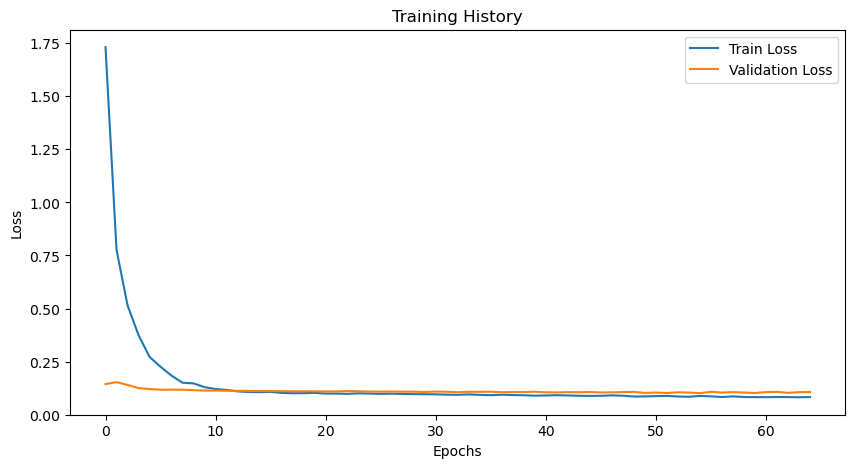

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Neural Network trained with MSE: 0.1012, MAE: 0.2143


In [24]:
result_nn1 = experiment_tda_nn(smr_df_path = smr_national_path,
                              cleaned_svi_data_path = scaled_svi_path,
                              save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                              variables = variables,
                              regex_filter = '_AV_ORI|_AL|SMR|FIPS',
                              model_name = 'ORIGINAL+AL-NN',
                              year='2018',
                              filter_method='down',
                              epochs=500,
                              batch_size=16)

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_down.csv already exists. Loading...

Merged dataframe shape: (2402, 87)

Feature columns: ['EP_POV_AML' 'EP_POV_AV_ORI' 'EP_UNEMP_AML' 'EP_UNEMP_AV_ORI'
 'EP_PCI_AML' 'EP_PCI_AV_ORI' 'EP_NOHSDP_AML' 'EP_NOHSDP_AV_ORI'
 'EP_UNINSUR_AML' 'EP_UNINSUR_AV_ORI' 'EP_AGE65_AML' 'EP_AGE65_AV_ORI'
 'EP_AGE17_AML' 'EP_AGE17_AV_ORI' 'EP_DISABL_AML' 'EP_DISABL_AV_ORI'
 'EP_SNGPNT_AML' 'EP_SNGPNT_AV_ORI' 'EP_LIMENG_AML' 'EP_LIMENG_AV_ORI'
 'EP_MINRTY_AML' 'EP_MINRTY_AV_ORI' 'EP_MUNIT_AML' 'EP_MUNIT_AV_ORI'
 'EP_MOBILE_AML' 'EP_MOBILE_AV_ORI' 'EP_CROWD_AML' 'EP_CROWD_AV_ORI'
 'EP_NOVEH_AML' 'EP_NOVEH_AV_ORI' 'EP_GROUPQ_AML' 'EP_GROUPQ_AV_ORI']
Epoch 1/500


/Users/h6x/anaconda3/envs/pymc_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3972 - mae: 1.2060 - val_loss: 0.1739 - val_mae: 0.2671
Epoch 2/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 0.8329 - mae: 0.7171 - val_loss: 0.1399 - val_mae: 0.2709
Epoch 3/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5214 - mae: 0.5619 - val_loss: 0.1447 - val_mae: 0.2771
Epoch 4/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 0.3977 - mae: 0.4889 - val_loss: 0.1437 - val_mae: 0.2598
Epoch 5/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 0.2863 - mae: 0.4126 - val_loss: 0.1306 - val_mae: 0.2373
Epoch 6/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2102 - mae: 0.3522 - val_loss: 0.1174 - val_mae: 0.2267
Epoch 7/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 0.1735 - mae: 0.3182 - val_loss: 0.1137 - val_mae: 0.2232
Epoch 8/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 0.1552 - mae: 0.2953 - val_loss: 0.1146 - val_mae: 0.2204
Epoch 9/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/

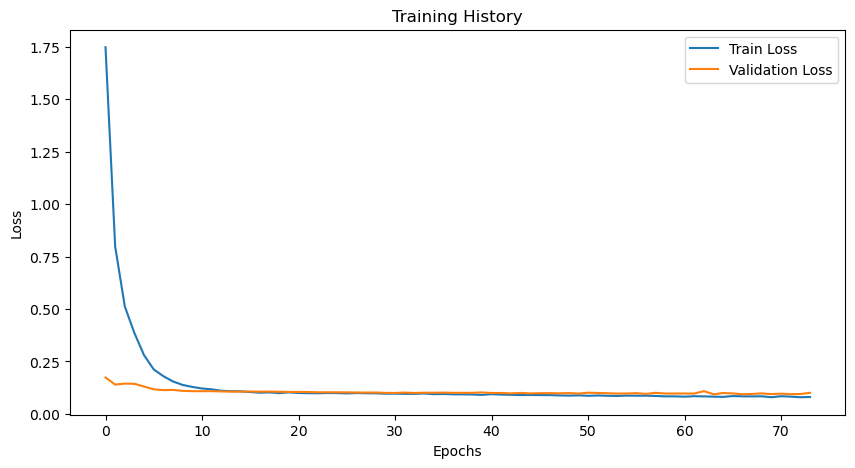

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Neural Network trained with MSE: 0.0938, MAE: 0.2117


In [25]:
result_nn2 = experiment_tda_nn(smr_df_path = smr_national_path,
                              cleaned_svi_data_path = scaled_svi_path,
                              save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                              variables = variables,
                              regex_filter = '_AV_ORI|_AML|SMR|FIPS',
                              model_name = 'ORIGINAL+AML-NN',
                              year='2018',
                              filter_method='down',
                              epochs=500,
                              batch_size=16)

In [51]:
results_df_down = pd.DataFrame([original, model_1_d, model_2_d, model_3_d, model_4_d, model_5_d, model_6_d, model_7_d, model_8_d, model_9_d, model_10_d, model_11_d, model_12_d, result_nn1, result_nn2])

In [61]:
results_df_down = results_df_down[['model_name', 'filtration', 'mse', 'r2', 'mae']]

In [62]:
# sort the results by mse
results_df_down.sort_values('mse', inplace=True)

/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_23304/3466728030.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_down.sort_values('mse', inplace=True)


In [63]:
results_df_down

,model_name,filtration,mse,r2,mae
8,ORIGINAL+AML,down,0.069398,0.121597,NaN
6,ORIGINAL+AL,down,0.069398,0.121597,NaN
10,ORIGINAL+AL+AML,down,0.069398,0.121597,NaN
12,ORIGINAL+AL+TML,down,0.069545,0.119741,NaN
11,ORIGINAL+TL+AML,down,0.069545,0.119741,NaN
9,ORIGINAL+TL+TML,down,0.070914,0.102412,NaN
7,ORIGINAL+TML,down,0.070914,0.102412,NaN
5,ORIGINAL+TL,down,0.070914,0.102412,NaN
0,ORIGINAL,down,0.073385,0.071128,NaN
1,AL,down,0.074191,0.060932,NaN


### UP FILTER

In [31]:
model_1_u = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_AL|SMR|FIPS', 
                    model_name = 'AL', 
                    year='2018', 
                    filter_method='up')

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_up.csv does not exists. Running...


Processing Counties: 100%|██████████| 3141/3141 [09:58<00:00,  5.25it/s] 


TDA summaries computed successfully.

Merged dataframe has shape: (2402, 86)

X columns: ['EP_POV_AL' 'EP_UNEMP_AL' 'EP_PCI_AL' 'EP_NOHSDP_AL' 'EP_UNINSUR_AL'
 'EP_AGE65_AL' 'EP_AGE17_AL' 'EP_DISABL_AL' 'EP_SNGPNT_AL' 'EP_LIMENG_AL'
 'EP_MINRTY_AL' 'EP_MUNIT_AL' 'EP_MOBILE_AL' 'EP_CROWD_AL' 'EP_NOVEH_AL'
 'EP_GROUPQ_AL']

Number of variables: 16

------Results------

Regression model traind with MSE: 0.07689333840213165 and R2: 0.026726699988301128


In [46]:
model_2_u = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_TL|SMR|FIPS', 
                    model_name = 'TL', 
                    year='2018', 
                    filter_method='up')

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_up.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_TL' 'EP_UNEMP_TL' 'EP_PCI_TL' 'EP_NOHSDP_TL' 'EP_UNINSUR_TL'
 'EP_AGE65_TL' 'EP_AGE17_TL' 'EP_DISABL_TL' 'EP_SNGPNT_TL' 'EP_LIMENG_TL'
 'EP_MINRTY_TL' 'EP_MUNIT_TL' 'EP_MOBILE_TL' 'EP_CROWD_TL' 'EP_NOVEH_TL'
 'EP_GROUPQ_TL']

Number of variables: 16

------Results------

Regression model traind with MSE: 0.07075863080887988 and R2: 0.10437643178516443


In [33]:
model_3_u = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_TML|SMR|FIPS', 
                    model_name = 'TML', 
                    year='2018', 
                    filter_method='up')

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_up.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_TML' 'EP_UNEMP_TML' 'EP_PCI_TML' 'EP_NOHSDP_TML' 'EP_UNINSUR_TML'
 'EP_AGE65_TML' 'EP_AGE17_TML' 'EP_DISABL_TML' 'EP_SNGPNT_TML'
 'EP_LIMENG_TML' 'EP_MINRTY_TML' 'EP_MUNIT_TML' 'EP_MOBILE_TML'
 'EP_CROWD_TML' 'EP_NOVEH_TML' 'EP_GROUPQ_TML']

Number of variables: 16

------Results------

Regression model traind with MSE: 0.07075863080887988 and R2: 0.10437643178516443


In [34]:
model_4_u = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_AML|SMR|FIPS', 
                    model_name = 'AML', 
                    year='2018', 
                    filter_method='up')


File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_up.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_AML' 'EP_UNEMP_AML' 'EP_PCI_AML' 'EP_NOHSDP_AML' 'EP_UNINSUR_AML'
 'EP_AGE65_AML' 'EP_AGE17_AML' 'EP_DISABL_AML' 'EP_SNGPNT_AML'
 'EP_LIMENG_AML' 'EP_MINRTY_AML' 'EP_MUNIT_AML' 'EP_MOBILE_AML'
 'EP_CROWD_AML' 'EP_NOVEH_AML' 'EP_GROUPQ_AML']

Number of variables: 16

------Results------

Regression model traind with MSE: 0.07689333840213163 and R2: 0.02672669998830146


In [35]:
model_5_u = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_AV_ORI|_TL|SMR|FIPS', 
                    model_name = 'ORIGINAL+TL', 
                    year='2018', 
                    filter_method='up')

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_up.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_TL' 'EP_POV_AV_ORI' 'EP_UNEMP_TL' 'EP_UNEMP_AV_ORI' 'EP_PCI_TL'
 'EP_PCI_AV_ORI' 'EP_NOHSDP_TL' 'EP_NOHSDP_AV_ORI' 'EP_UNINSUR_TL'
 'EP_UNINSUR_AV_ORI' 'EP_AGE65_TL' 'EP_AGE65_AV_ORI' 'EP_AGE17_TL'
 'EP_AGE17_AV_ORI' 'EP_DISABL_TL' 'EP_DISABL_AV_ORI' 'EP_SNGPNT_TL'
 'EP_SNGPNT_AV_ORI' 'EP_LIMENG_TL' 'EP_LIMENG_AV_ORI' 'EP_MINRTY_TL'
 'EP_MINRTY_AV_ORI' 'EP_MUNIT_TL' 'EP_MUNIT_AV_ORI' 'EP_MOBILE_TL'
 'EP_MOBILE_AV_ORI' 'EP_CROWD_TL' 'EP_CROWD_AV_ORI' 'EP_NOVEH_TL'
 'EP_NOVEH_AV_ORI' 'EP_GROUPQ_TL' 'EP_GROUPQ_AV_ORI']

Number of variables: 32

------Results------

Regression model traind with MSE: 0.06947436864813693 and R2: 0.1206319110924825


In [36]:
model_6_u = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_AV_ORI|_AL|SMR|FIPS', 
                    model_name = 'ORIGINAL+AL', 
                    year='2018', 
                    filter_method='up')

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_up.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_AL' 'EP_POV_AV_ORI' 'EP_UNEMP_AL' 'EP_UNEMP_AV_ORI' 'EP_PCI_AL'
 'EP_PCI_AV_ORI' 'EP_NOHSDP_AL' 'EP_NOHSDP_AV_ORI' 'EP_UNINSUR_AL'
 'EP_UNINSUR_AV_ORI' 'EP_AGE65_AL' 'EP_AGE65_AV_ORI' 'EP_AGE17_AL'
 'EP_AGE17_AV_ORI' 'EP_DISABL_AL' 'EP_DISABL_AV_ORI' 'EP_SNGPNT_AL'
 'EP_SNGPNT_AV_ORI' 'EP_LIMENG_AL' 'EP_LIMENG_AV_ORI' 'EP_MINRTY_AL'
 'EP_MINRTY_AV_ORI' 'EP_MUNIT_AL' 'EP_MUNIT_AV_ORI' 'EP_MOBILE_AL'
 'EP_MOBILE_AV_ORI' 'EP_CROWD_AL' 'EP_CROWD_AV_ORI' 'EP_NOVEH_AL'
 'EP_NOVEH_AV_ORI' 'EP_GROUPQ_AL' 'EP_GROUPQ_AV_ORI']

Number of variables: 32

------Results------

Regression model traind with MSE: 0.07518160938054515 and R2: 0.04839281812265317


In [37]:
model_7_u = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_AV_ORI|_TML|SMR|FIPS', 
                    model_name = 'ORIGINAL+TML', 
                    year='2018', 
                    filter_method='up')

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_up.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_TML' 'EP_POV_AV_ORI' 'EP_UNEMP_TML' 'EP_UNEMP_AV_ORI'
 'EP_PCI_TML' 'EP_PCI_AV_ORI' 'EP_NOHSDP_TML' 'EP_NOHSDP_AV_ORI'
 'EP_UNINSUR_TML' 'EP_UNINSUR_AV_ORI' 'EP_AGE65_TML' 'EP_AGE65_AV_ORI'
 'EP_AGE17_TML' 'EP_AGE17_AV_ORI' 'EP_DISABL_TML' 'EP_DISABL_AV_ORI'
 'EP_SNGPNT_TML' 'EP_SNGPNT_AV_ORI' 'EP_LIMENG_TML' 'EP_LIMENG_AV_ORI'
 'EP_MINRTY_TML' 'EP_MINRTY_AV_ORI' 'EP_MUNIT_TML' 'EP_MUNIT_AV_ORI'
 'EP_MOBILE_TML' 'EP_MOBILE_AV_ORI' 'EP_CROWD_TML' 'EP_CROWD_AV_ORI'
 'EP_NOVEH_TML' 'EP_NOVEH_AV_ORI' 'EP_GROUPQ_TML' 'EP_GROUPQ_AV_ORI']

Number of variables: 32

------Results------

Regression model traind with MSE: 0.06947436864813696 and R2: 0.12063191109248217


In [38]:
model_8_u = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_AV_ORI|_AML|SMR|FIPS', 
                    model_name = 'ORIGINAL+AML', 
                    year='2018', 
                    filter_method='up')

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_up.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_AML' 'EP_POV_AV_ORI' 'EP_UNEMP_AML' 'EP_UNEMP_AV_ORI'
 'EP_PCI_AML' 'EP_PCI_AV_ORI' 'EP_NOHSDP_AML' 'EP_NOHSDP_AV_ORI'
 'EP_UNINSUR_AML' 'EP_UNINSUR_AV_ORI' 'EP_AGE65_AML' 'EP_AGE65_AV_ORI'
 'EP_AGE17_AML' 'EP_AGE17_AV_ORI' 'EP_DISABL_AML' 'EP_DISABL_AV_ORI'
 'EP_SNGPNT_AML' 'EP_SNGPNT_AV_ORI' 'EP_LIMENG_AML' 'EP_LIMENG_AV_ORI'
 'EP_MINRTY_AML' 'EP_MINRTY_AV_ORI' 'EP_MUNIT_AML' 'EP_MUNIT_AV_ORI'
 'EP_MOBILE_AML' 'EP_MOBILE_AV_ORI' 'EP_CROWD_AML' 'EP_CROWD_AV_ORI'
 'EP_NOVEH_AML' 'EP_NOVEH_AV_ORI' 'EP_GROUPQ_AML' 'EP_GROUPQ_AV_ORI']

Number of variables: 32

------Results------

Regression model traind with MSE: 0.0751816093805451 and R2: 0.048392818122653725


Multiple combinations of the original data

In [39]:
model_9_u = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_AV_ORI|_TL|_TML|SMR|FIPS', 
                    model_name = 'ORIGINAL+TL+TML', 
                    year='2018', 
                    filter_method='up')

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_up.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_TL' 'EP_POV_TML' 'EP_POV_AV_ORI' 'EP_UNEMP_TL' 'EP_UNEMP_TML'
 'EP_UNEMP_AV_ORI' 'EP_PCI_TL' 'EP_PCI_TML' 'EP_PCI_AV_ORI' 'EP_NOHSDP_TL'
 'EP_NOHSDP_TML' 'EP_NOHSDP_AV_ORI' 'EP_UNINSUR_TL' 'EP_UNINSUR_TML'
 'EP_UNINSUR_AV_ORI' 'EP_AGE65_TL' 'EP_AGE65_TML' 'EP_AGE65_AV_ORI'
 'EP_AGE17_TL' 'EP_AGE17_TML' 'EP_AGE17_AV_ORI' 'EP_DISABL_TL'
 'EP_DISABL_TML' 'EP_DISABL_AV_ORI' 'EP_SNGPNT_TL' 'EP_SNGPNT_TML'
 'EP_SNGPNT_AV_ORI' 'EP_LIMENG_TL' 'EP_LIMENG_TML' 'EP_LIMENG_AV_ORI'
 'EP_MINRTY_TL' 'EP_MINRTY_TML' 'EP_MINRTY_AV_ORI' 'EP_MUNIT_TL'
 'EP_MUNIT_TML' 'EP_MUNIT_AV_ORI' 'EP_MOBILE_TL' 'EP_MOBILE_TML'
 'EP_MOBILE_AV_ORI' 'EP_CROWD_TL' 'EP_CROWD_TML' 'EP_CROWD_AV_ORI'
 'EP_NOVEH_TL' 'EP_NOVEH_TML' 'EP_NOVEH_AV_ORI' 'EP_GROUPQ_TL'
 'EP_GROUPQ_TML' 'EP_GROUPQ_AV_ORI']

Number of variables: 48

-

In [40]:
model_10_u = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_AV_ORI|_AL|_AML|SMR|FIPS', 
                    model_name = 'ORIGINAL+AL+AML', 
                    year='2018', 
                    filter_method='up')

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_up.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_AL' 'EP_POV_AML' 'EP_POV_AV_ORI' 'EP_UNEMP_AL' 'EP_UNEMP_AML'
 'EP_UNEMP_AV_ORI' 'EP_PCI_AL' 'EP_PCI_AML' 'EP_PCI_AV_ORI' 'EP_NOHSDP_AL'
 'EP_NOHSDP_AML' 'EP_NOHSDP_AV_ORI' 'EP_UNINSUR_AL' 'EP_UNINSUR_AML'
 'EP_UNINSUR_AV_ORI' 'EP_AGE65_AL' 'EP_AGE65_AML' 'EP_AGE65_AV_ORI'
 'EP_AGE17_AL' 'EP_AGE17_AML' 'EP_AGE17_AV_ORI' 'EP_DISABL_AL'
 'EP_DISABL_AML' 'EP_DISABL_AV_ORI' 'EP_SNGPNT_AL' 'EP_SNGPNT_AML'
 'EP_SNGPNT_AV_ORI' 'EP_LIMENG_AL' 'EP_LIMENG_AML' 'EP_LIMENG_AV_ORI'
 'EP_MINRTY_AL' 'EP_MINRTY_AML' 'EP_MINRTY_AV_ORI' 'EP_MUNIT_AL'
 'EP_MUNIT_AML' 'EP_MUNIT_AV_ORI' 'EP_MOBILE_AL' 'EP_MOBILE_AML'
 'EP_MOBILE_AV_ORI' 'EP_CROWD_AL' 'EP_CROWD_AML' 'EP_CROWD_AV_ORI'
 'EP_NOVEH_AL' 'EP_NOVEH_AML' 'EP_NOVEH_AV_ORI' 'EP_GROUPQ_AL'
 'EP_GROUPQ_AML' 'EP_GROUPQ_AV_ORI']

Number of variables: 48

-

In [41]:
model_11_u = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_AV_ORI|_TL|_AML|SMR|FIPS', 
                    model_name = 'ORIGINAL+TL+AML', 
                    year='2018', 
                    filter_method='up')

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_up.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_TL' 'EP_POV_AML' 'EP_POV_AV_ORI' 'EP_UNEMP_TL' 'EP_UNEMP_AML'
 'EP_UNEMP_AV_ORI' 'EP_PCI_TL' 'EP_PCI_AML' 'EP_PCI_AV_ORI' 'EP_NOHSDP_TL'
 'EP_NOHSDP_AML' 'EP_NOHSDP_AV_ORI' 'EP_UNINSUR_TL' 'EP_UNINSUR_AML'
 'EP_UNINSUR_AV_ORI' 'EP_AGE65_TL' 'EP_AGE65_AML' 'EP_AGE65_AV_ORI'
 'EP_AGE17_TL' 'EP_AGE17_AML' 'EP_AGE17_AV_ORI' 'EP_DISABL_TL'
 'EP_DISABL_AML' 'EP_DISABL_AV_ORI' 'EP_SNGPNT_TL' 'EP_SNGPNT_AML'
 'EP_SNGPNT_AV_ORI' 'EP_LIMENG_TL' 'EP_LIMENG_AML' 'EP_LIMENG_AV_ORI'
 'EP_MINRTY_TL' 'EP_MINRTY_AML' 'EP_MINRTY_AV_ORI' 'EP_MUNIT_TL'
 'EP_MUNIT_AML' 'EP_MUNIT_AV_ORI' 'EP_MOBILE_TL' 'EP_MOBILE_AML'
 'EP_MOBILE_AV_ORI' 'EP_CROWD_TL' 'EP_CROWD_AML' 'EP_CROWD_AV_ORI'
 'EP_NOVEH_TL' 'EP_NOVEH_AML' 'EP_NOVEH_AV_ORI' 'EP_GROUPQ_TL'
 'EP_GROUPQ_AML' 'EP_GROUPQ_AV_ORI']

Number of variables: 48

-

In [42]:
model_12_u = experiment_tda(smr_df_path = smr_national_path, 
                    cleaned_svi_data_path=scaled_svi_path,
                    save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                    variables = variables,
                    regex_filter = '_AV_ORI|_AL|_TML|SMR|FIPS', 
                    model_name = 'ORIGINAL+AL+TML', 
                    year='2018', 
                    filter_method='up')

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_up.csv already exists. Skipping...

Merged dataframe has shape: (2402, 87)

X columns: ['EP_POV_AL' 'EP_POV_TML' 'EP_POV_AV_ORI' 'EP_UNEMP_AL' 'EP_UNEMP_TML'
 'EP_UNEMP_AV_ORI' 'EP_PCI_AL' 'EP_PCI_TML' 'EP_PCI_AV_ORI' 'EP_NOHSDP_AL'
 'EP_NOHSDP_TML' 'EP_NOHSDP_AV_ORI' 'EP_UNINSUR_AL' 'EP_UNINSUR_TML'
 'EP_UNINSUR_AV_ORI' 'EP_AGE65_AL' 'EP_AGE65_TML' 'EP_AGE65_AV_ORI'
 'EP_AGE17_AL' 'EP_AGE17_TML' 'EP_AGE17_AV_ORI' 'EP_DISABL_AL'
 'EP_DISABL_TML' 'EP_DISABL_AV_ORI' 'EP_SNGPNT_AL' 'EP_SNGPNT_TML'
 'EP_SNGPNT_AV_ORI' 'EP_LIMENG_AL' 'EP_LIMENG_TML' 'EP_LIMENG_AV_ORI'
 'EP_MINRTY_AL' 'EP_MINRTY_TML' 'EP_MINRTY_AV_ORI' 'EP_MUNIT_AL'
 'EP_MUNIT_TML' 'EP_MUNIT_AV_ORI' 'EP_MOBILE_AL' 'EP_MOBILE_TML'
 'EP_MOBILE_AV_ORI' 'EP_CROWD_AL' 'EP_CROWD_TML' 'EP_CROWD_AV_ORI'
 'EP_NOVEH_AL' 'EP_NOVEH_TML' 'EP_NOVEH_AV_ORI' 'EP_GROUPQ_AL'
 'EP_GROUPQ_TML' 'EP_GROUPQ_AV_ORI']

Number of variables: 48

-

NN Models

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_up.csv already exists. Loading...

Merged dataframe shape: (2402, 87)

Feature columns: ['EP_POV_AL' 'EP_POV_AV_ORI' 'EP_UNEMP_AL' 'EP_UNEMP_AV_ORI' 'EP_PCI_AL'
 'EP_PCI_AV_ORI' 'EP_NOHSDP_AL' 'EP_NOHSDP_AV_ORI' 'EP_UNINSUR_AL'
 'EP_UNINSUR_AV_ORI' 'EP_AGE65_AL' 'EP_AGE65_AV_ORI' 'EP_AGE17_AL'
 'EP_AGE17_AV_ORI' 'EP_DISABL_AL' 'EP_DISABL_AV_ORI' 'EP_SNGPNT_AL'
 'EP_SNGPNT_AV_ORI' 'EP_LIMENG_AL' 'EP_LIMENG_AV_ORI' 'EP_MINRTY_AL'
 'EP_MINRTY_AV_ORI' 'EP_MUNIT_AL' 'EP_MUNIT_AV_ORI' 'EP_MOBILE_AL'
 'EP_MOBILE_AV_ORI' 'EP_CROWD_AL' 'EP_CROWD_AV_ORI' 'EP_NOVEH_AL'
 'EP_NOVEH_AV_ORI' 'EP_GROUPQ_AL' 'EP_GROUPQ_AV_ORI']
Epoch 1/500


/Users/h6x/anaconda3/envs/pymc_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.1922 - mae: 1.1463 - val_loss: 0.1426 - val_mae: 0.2398
Epoch 2/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 0.7683 - mae: 0.6875 - val_loss: 0.1526 - val_mae: 0.3032
Epoch 3/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 0.5529 - mae: 0.5790 - val_loss: 0.1369 - val_mae: 0.2718
Epoch 4/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 0.4081 - mae: 0.4884 - val_loss: 0.1223 - val_mae: 0.2453
Epoch 5/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 0.2924 - mae: 0.4125 - val_loss: 0.1161 - val_mae: 0.2247
Epoch 6/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 0.2237 - mae: 0.3585 - val_loss: 0.1113 - val_mae: 0.2239
Epoch 7/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 0.1905 - mae: 0.3363 - val_loss: 0.1116 - val_mae: 0.2205
Epoch 8/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 0.1631 - mae: 0.3072 - val_loss: 0.1110 - val_mae: 0.2206
Epoch 9/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 89

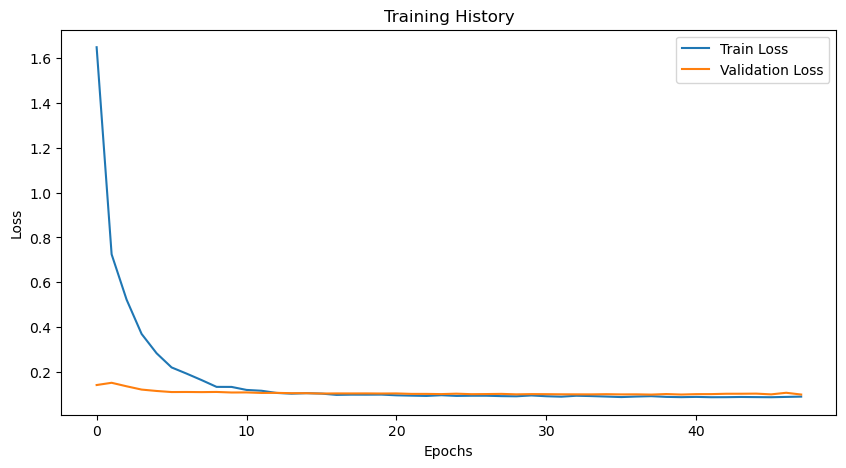

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Neural Network trained with MSE: 0.1000, MAE: 0.2175


In [43]:
result_nn1_u = experiment_tda_nn(smr_df_path = smr_national_path,
                              cleaned_svi_data_path = scaled_svi_path,
                              save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                              variables = variables,
                              regex_filter = '_AV_ORI|_AL|SMR|FIPS',
                              model_name = 'ORIGINAL+AL-NN',
                              year='2018',
                              filter_method='up',
                              epochs=500,
                              batch_size=16)

File /Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed/tda_svi_summaries_2018_up.csv already exists. Loading...

Merged dataframe shape: (2402, 87)

Feature columns: ['EP_POV_AML' 'EP_POV_AV_ORI' 'EP_UNEMP_AML' 'EP_UNEMP_AV_ORI'
 'EP_PCI_AML' 'EP_PCI_AV_ORI' 'EP_NOHSDP_AML' 'EP_NOHSDP_AV_ORI'
 'EP_UNINSUR_AML' 'EP_UNINSUR_AV_ORI' 'EP_AGE65_AML' 'EP_AGE65_AV_ORI'
 'EP_AGE17_AML' 'EP_AGE17_AV_ORI' 'EP_DISABL_AML' 'EP_DISABL_AV_ORI'
 'EP_SNGPNT_AML' 'EP_SNGPNT_AV_ORI' 'EP_LIMENG_AML' 'EP_LIMENG_AV_ORI'
 'EP_MINRTY_AML' 'EP_MINRTY_AV_ORI' 'EP_MUNIT_AML' 'EP_MUNIT_AV_ORI'
 'EP_MOBILE_AML' 'EP_MOBILE_AV_ORI' 'EP_CROWD_AML' 'EP_CROWD_AV_ORI'
 'EP_NOVEH_AML' 'EP_NOVEH_AV_ORI' 'EP_GROUPQ_AML' 'EP_GROUPQ_AV_ORI']
Epoch 1/500


/Users/h6x/anaconda3/envs/pymc_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3047 - mae: 1.1777 - val_loss: 0.1493 - val_mae: 0.2407
Epoch 2/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 0.8108 - mae: 0.7009 - val_loss: 0.1654 - val_mae: 0.3281
Epoch 3/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4972 - mae: 0.5480 - val_loss: 0.1459 - val_mae: 0.2885
Epoch 4/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4093 - mae: 0.4992 - val_loss: 0.1313 - val_mae: 0.2579
Epoch 5/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2958 - mae: 0.4106 - val_loss: 0.1151 - val_mae: 0.2268
Epoch 6/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 0.2269 - mae: 0.3671 - val_loss: 0.1105 - val_mae: 0.2212
Epoch 7/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 0.1935 - mae: 0.3351 - val_loss: 0.1103 - val_mae: 0.2201
Epoch 8/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1522 - mae: 0.3001 - val_loss: 0.1104 - val_mae: 0.2189
Epoch 9/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

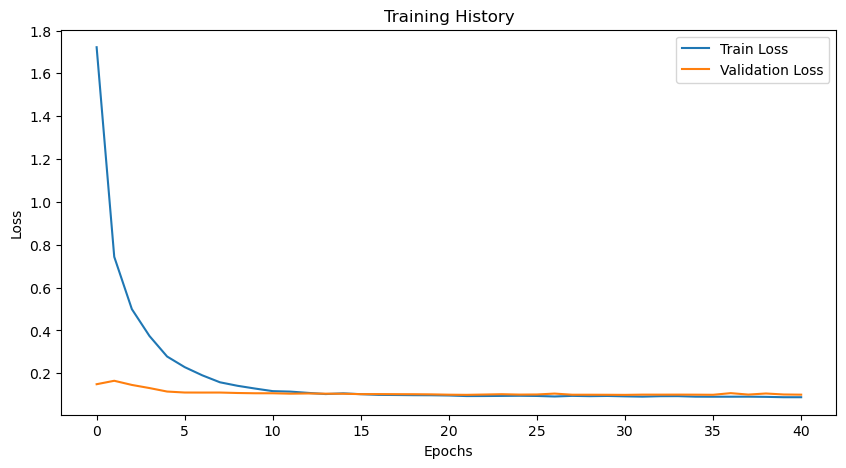

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Neural Network trained with MSE: 0.0996, MAE: 0.2157


In [44]:
result_nn2_u = experiment_tda_nn(smr_df_path = smr_national_path,
                              cleaned_svi_data_path = scaled_svi_path,
                              save_path = "/Users/h6x/ORNL/git/WORKSTAION GIT/nvss-experiments/usa_models/data/processed",
                              variables = variables,
                              regex_filter = '_AV_ORI|_AML|SMR|FIPS',
                              model_name = 'ORIGINAL+AML-NN',
                              year='2018',
                              filter_method='up',
                              epochs=500,
                              batch_size=16)

In [47]:
results_df_up = pd.DataFrame([original, model_1_u, model_2_u, model_3_u, model_4_u, model_5_u, model_6_u, model_7_u, model_8_u, model_9_u, model_10_u, model_11_u, model_12_u, result_nn1_u, result_nn2_u])

results_df_up = results_df_up[['model_name', 'filtration', 'mse', 'r2', 'mae']]

# sort the results by mse
results_df_up.sort_values('mse', inplace=True)

In [48]:
results_df_up

,model_name,filtration,mse,r2,mae
5,ORIGINAL+TL,up,0.069474,0.120632,NaN
7,ORIGINAL+TML,up,0.069474,0.120632,NaN
9,ORIGINAL+TL+TML,up,0.069474,0.120632,NaN
11,ORIGINAL+TL+AML,up,0.070625,0.106070,NaN
12,ORIGINAL+AL+TML,up,0.070625,0.106070,NaN
2,TL,up,0.070759,0.104376,NaN
3,TML,up,0.070759,0.104376,NaN
0,ORIGINAL,down,0.073385,0.071128,NaN
8,ORIGINAL+AML,up,0.075182,0.048393,NaN
10,ORIGINAL+AL+AML,up,0.075182,0.048393,NaN


In [57]:
# combine the results df
results_df = pd.concat([results_df_down, results_df_up])

# sort the results by mse
results_df.sort_values('mse', inplace=True)

In [59]:
results_df = results_df[['model_name', 'filtration', 'mse', 'r2', 'mae']]

In [60]:
results_df

,model_name,filtration,mse,r2,mae
8,ORIGINAL+AML,down,0.069398,0.121597,NaN
6,ORIGINAL+AL,down,0.069398,0.121597,NaN
10,ORIGINAL+AL+AML,down,0.069398,0.121597,NaN
5,ORIGINAL+TL,up,0.069474,0.120632,NaN
7,ORIGINAL+TML,up,0.069474,0.120632,NaN
9,ORIGINAL+TL+TML,up,0.069474,0.120632,NaN
12,ORIGINAL+AL+TML,down,0.069545,0.119741,NaN
11,ORIGINAL+TL+AML,down,0.069545,0.119741,NaN
11,ORIGINAL+TL+AML,up,0.070625,0.106070,NaN
12,ORIGINAL+AL+TML,up,0.070625,0.106070,NaN
